<a href="https://colab.research.google.com/github/mubrij/AI_ML_for_5G_Energy_Consumption_Modelling_by_ITU_AI_ML_in_5G_Challenge/blob/main/African_Credit_Scoring_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost -qq
!pip install lightgbm -qq
!pip install xgboost -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from IPython.display import Markdown, display

SEED=4

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Loading

In [3]:
PATH = "/content/drive/MyDrive/African Credit Scoring Challenge"

In [4]:
train = pd.read_csv(PATH + "/Train (23).csv")
test = pd.read_csv(PATH + "/Test (21).csv")
ss = pd.read_csv(PATH + "/SampleSubmission (44).csv")
ei = pd.read_csv(PATH + "/economic_indicators.csv")

#EDA

In [5]:
def load_markdown(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return content
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

def display_markdown(content):
    if content:
        display(Markdown(content))
    else:
        print("No content to display.")

file_path = PATH + "/VariableDefinitions.txt"
markdown_content = load_markdown(file_path)
display_markdown(markdown_content)

## Description of variables in Train/Test.csv

0. **ID**: A unique identifier for each entry in the dataset.

1. **customer_id**: Unique identifier for each customer in the dataset.

2. **country_id**: Identifier or code representing the country where the customer resides or where the loan was issued.

3. **tbl_loan_id**: Unique identifier for each loan associated with the customer.

4. **Total_Amount**: The total loan amount initially disbursed to the customer.

5. **Total_Amount_to_Repay**: The total amount the customer is expected to repay, including principal, interest, and fees.

6. **interest_amount**: The interest charged on the loan as part of the repayment amount.

7. **loan_type**: The category or type of loan.

8. **disbursement_date**: The date when the loan amount was disbursed to the customer.

9. **duration**: The length of the loan term, typically expressed in days

10. **lender_id**: Unique identifier for the lender or institution that issued the loan.

11. **New_versus_Repeat**: Indicates whether the loan is the customer's first loan ("New") or if the customer has taken loans before ("Repeat").

12. **Amount_Funded_By_Lender**: The portion of the loan funded directly by the lender.

13. **Lender_portion_Funded**: Percentage of the total loan amount funded by the lender.

14. **due_date**: The date by which the loan repayment is due.

15. **Lender_portion_to_be_repaid**: The portion of the outstanding loan that needs to be repaid to the lender.

16. **target**: This variables takes the value 0 or 1. 1 means the customer defaulted on the loan, whereas 0 means, the customer paid the loan.


In [6]:
train.shape, test.shape, ss.shape, ei.shape

((68654, 16), (18594, 15), (18594, 2), (27, 25))

In [7]:
ei.head()

,Country,Indicator,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,...,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023
0,Ghana,"Inflation, consumer prices (annual %)",41.509496,9.360932,29.772980,18.042739,15.438992,11.679184,10.734267,16.494640,...,15.489616,17.149970,17.454635,12.371922,7.808765,7.143640,9.887290,9.971089,31.255895,38.106966
1,Cote d'Ivoire,"Inflation, consumer prices (annual %)",4.361529,3.077265,3.296807,1.457988,3.885830,2.467191,1.892006,6.308528,...,0.448682,1.251500,0.723178,0.685881,0.359409,-1.106863,2.425007,4.091952,5.276167,4.387117
2,Kenya,"Inflation, consumer prices (annual %)",5.738598,1.961308,9.815691,11.624036,10.312778,14.453734,9.758880,26.239817,...,6.878155,6.582154,6.297250,8.005650,4.689806,5.239638,5.405162,6.107936,7.659863,7.671396
3,Ghana,"Official exchange rate (LCU per US$, period av...",0.716305,0.792417,0.866764,0.899495,0.905209,0.915107,0.932619,1.052275,...,2.896575,3.714642,3.909817,4.350533,4.585325,5.217367,5.595708,5.805700,8.272400,11.020408
4,Cote d'Ivoire,"Official exchange rate (LCU per US$, period av...",732.397693,693.713226,579.897426,527.338032,527.258363,522.425625,478.633718,446.000041,...,493.757330,591.211698,592.605615,580.656750,555.446458,585.911013,575.586005,554.530675,623.759701,606.569750


In [8]:
def print_unique_counts(df):
    for column in df.columns:
        unique_count = df[column].nunique()
        print(f"Column '{column}': {unique_count} unique value(s)")

In [9]:
print("*"*20, "Train", "*"*20)
print_unique_counts(train)
print("*"*20, "Test", "*"*20)
print_unique_counts(test)

******************** Train ********************
Column 'ID': 68654 unique value(s)
Column 'customer_id': 6540 unique value(s)
Column 'country_id': 1 unique value(s)
Column 'tbl_loan_id': 66520 unique value(s)
Column 'lender_id': 4 unique value(s)
Column 'loan_type': 22 unique value(s)
Column 'Total_Amount': 19076 unique value(s)
Column 'Total_Amount_to_Repay': 21920 unique value(s)
Column 'disbursement_date': 768 unique value(s)
Column 'due_date': 893 unique value(s)
Column 'duration': 64 unique value(s)
Column 'New_versus_Repeat': 2 unique value(s)
Column 'Amount_Funded_By_Lender': 23391 unique value(s)
Column 'Lender_portion_Funded': 12844 unique value(s)
Column 'Lender_portion_to_be_repaid': 9791 unique value(s)
Column 'target': 2 unique value(s)
******************** Test ********************
Column 'ID': 18594 unique value(s)
Column 'customer_id': 4962 unique value(s)
Column 'country_id': 2 unique value(s)
Column 'tbl_loan_id': 17067 unique value(s)
Column 'lender_id': 8 unique val

In [10]:
ei.head()

,Country,Indicator,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,...,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023
0,Ghana,"Inflation, consumer prices (annual %)",41.509496,9.360932,29.772980,18.042739,15.438992,11.679184,10.734267,16.494640,...,15.489616,17.149970,17.454635,12.371922,7.808765,7.143640,9.887290,9.971089,31.255895,38.106966
1,Cote d'Ivoire,"Inflation, consumer prices (annual %)",4.361529,3.077265,3.296807,1.457988,3.885830,2.467191,1.892006,6.308528,...,0.448682,1.251500,0.723178,0.685881,0.359409,-1.106863,2.425007,4.091952,5.276167,4.387117
2,Kenya,"Inflation, consumer prices (annual %)",5.738598,1.961308,9.815691,11.624036,10.312778,14.453734,9.758880,26.239817,...,6.878155,6.582154,6.297250,8.005650,4.689806,5.239638,5.405162,6.107936,7.659863,7.671396
3,Ghana,"Official exchange rate (LCU per US$, period av...",0.716305,0.792417,0.866764,0.899495,0.905209,0.915107,0.932619,1.052275,...,2.896575,3.714642,3.909817,4.350533,4.585325,5.217367,5.595708,5.805700,8.272400,11.020408
4,Cote d'Ivoire,"Official exchange rate (LCU per US$, period av...",732.397693,693.713226,579.897426,527.338032,527.258363,522.425625,478.633718,446.000041,...,493.757330,591.211698,592.605615,580.656750,555.446458,585.911013,575.586005,554.530675,623.759701,606.569750


In [11]:
kenya_df = ei[ei['Country'] == 'Kenya'].fillna(-9999)
ghana_df = ei[ei['Country'] == 'Ghana'].fillna(-9999)

In [14]:
from tqdm import tqdm

def add_indicator_values(df, date_column, kenya_df, ghana_df, indicators_mapping):
    """
    Adds indicator values to the DataFrame based on the specified date column and country.

    Args:
        df (pd.DataFrame): The DataFrame to update (train or test).
        date_column (str): Column name in `df` containing date strings (e.g., 'disbursement_date').
        kenya_df (pd.DataFrame): DataFrame containing Kenya's indicators and yearly values.
        ghana_df (pd.DataFrame): DataFrame containing Ghana's indicators and yearly values.
        indicators_mapping (dict): A mapping of new column names to indicator names in `kenya_df` and `ghana_df`.
    """
    for new_column, indicator_name in indicators_mapping.items():
        df[new_column] = np.nan  # Initialize new column with NaN values

        for id, data in tqdm(enumerate(df[date_column]), desc=f'Adding {new_column}'):
            year = data.split('-')[0]
            target_year = '2023' if year in ['2024', '2025'] else year  # Handle special year cases

            # Determine country and select the appropriate DataFrame
            if df['country_id'].iloc[id] == 'Kenya':
                value = kenya_df.loc[
                    kenya_df['Indicator'] == indicator_name, f'YR{target_year}'
                ].values
            else:  # Assume 'Ghana' if not Kenya
                value = ghana_df.loc[
                    ghana_df['Indicator'] == indicator_name, f'YR{target_year}'
                ].values

            # Assign the value if it exists, else keep NaN
            df.loc[id, new_column] = value[0] if len(value) > 0 else np.nan

    return df

# Mapping of new column names to the corresponding indicators in `kenya_df`
indicators_mapping = {
    'real_interest_rate_at_disbursement': 'Real interest rate (%)',
    'Inflation_consumer_prices_(annual %)_at_disbursement': 'Inflation, consumer prices (annual %)',
    'Official_exchange_rate_(LCU per US$, period average)_at_disbursement': 'Official exchange rate (LCU per US$, period average)',
    'Average_precipitation_in_depth_(mm per year)_at_disbursement': 'Average precipitation in depth (mm per year)',
    'Deposit_interest_rate_(%)_at_disbursement': 'Deposit interest rate (%)',
    'Lending_interest_rate_(%)_at_disbursement': 'Lending interest rate (%)',
    'Interest_rate_spread_(lending rate minus deposit rate, %)_at_disbursement': 'Interest rate spread (lending rate minus deposit rate, %)',
    'Fossil_fuel_energy_consumption_(% of total)_at_disbursement': 'Fossil fuel energy consumption (% of total)',
    'Unemployment_rate_at_disbursement': 'Unemployment rate'
}

# Apply for disbursement date
train = add_indicator_values(train, 'disbursement_date', kenya_df, ghana_df, indicators_mapping)

# Adjust mapping for due date
indicators_mapping_due_date = {
    k.replace('disbursement', 'due'): v for k, v in indicators_mapping.items()
}

# Apply for due date
train = add_indicator_values(train, 'due_date', kenya_df, ghana_df, indicators_mapping_due_date)

# Add indicators for disbursement_date
test = add_indicator_values(test, 'disbursement_date', kenya_df, ghana_df, indicators_mapping)
# Add indicators for due_date
test = add_indicator_values(test, 'due_date', kenya_df, ghana_df, indicators_mapping_due_date)


Adding real_interest_rate_at_disbursement: 68654it [01:00, 1134.72it/s]
Adding Inflation_consumer_prices_(annual %)_at_disbursement: 68654it [00:57, 1192.65it/s]
Adding Official_exchange_rate_(LCU per US$, period average)_at_disbursement: 68654it [00:54, 1270.00it/s]
Adding Average_precipitation_in_depth_(mm per year)_at_disbursement: 68654it [00:55, 1245.09it/s]
Adding Deposit_interest_rate_(%)_at_disbursement: 68654it [00:56, 1220.84it/s]
Adding Lending_interest_rate_(%)_at_disbursement: 68654it [00:54, 1268.06it/s]
Adding Interest_rate_spread_(lending rate minus deposit rate, %)_at_disbursement: 68654it [00:54, 1259.37it/s]
Adding Fossil_fuel_energy_consumption_(% of total)_at_disbursement: 68654it [00:54, 1263.23it/s]
Adding Unemployment_rate_at_disbursement: 68654it [00:56, 1223.80it/s]
Adding real_interest_rate_at_due: 68654it [00:54, 1250.02it/s]
Adding Inflation_consumer_prices_(annual %)_at_due: 68654it [00:55, 1235.46it/s]
Adding Official_exchange_rate_(LCU per US$, period av

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 34 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   ID                                                                         68654 non-null  object 
 1   customer_id                                                                68654 non-null  int64  
 2   country_id                                                                 68654 non-null  object 
 3   tbl_loan_id                                                                68654 non-null  int64  
 4   lender_id                                                                  68654 non-null  int64  
 5   loan_type                                                                  68654 non-null  object 
 6   Total_Amount                                          

In [16]:
numerical_columns = train.select_dtypes(include=['number']).columns.tolist()
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()

def filter_id_columns(columns):
    id_columns = [col for col in columns if 'id' in col.lower()]
    filtered_columns = [col for col in columns if col not in id_columns]
    return filtered_columns, id_columns

numerical_columns, id_columns_numerical = filter_id_columns(numerical_columns)
categorical_columns, id_columns_categorical = filter_id_columns(categorical_columns)

id_columns = id_columns_numerical + id_columns_categorical

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)
print("ID columns:", id_columns)

Numerical columns: ['Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'target', 'real_interest_rate_at_disbursement', 'Inflation_consumer_prices_(annual %)_at_disbursement', 'Official_exchange_rate_(LCU per US$, period average)_at_disbursement', 'Average_precipitation_in_depth_(mm per year)_at_disbursement', 'Deposit_interest_rate_(%)_at_disbursement', 'Lending_interest_rate_(%)_at_disbursement', 'Interest_rate_spread_(lending rate minus deposit rate, %)_at_disbursement', 'Fossil_fuel_energy_consumption_(% of total)_at_disbursement', 'Unemployment_rate_at_disbursement', 'real_interest_rate_at_due', 'Inflation_consumer_prices_(annual %)_at_due', 'Official_exchange_rate_(LCU per US$, period average)_at_due', 'Average_precipitation_in_depth_(mm per year)_at_due', 'Deposit_interest_rate_(%)_at_due', 'Lending_interest_rate_(%)_at_due', 'Interest_rate_spread_(lending rate minus deposit rate, %)_at_due', 'Fossil_fuel_energy_consumption_(%

In [17]:
train[categorical_columns]

,loan_type,disbursement_date,due_date,New_versus_Repeat
0,Type_1,2022-08-30,2022-09-06,Repeat Loan
1,Type_1,2022-07-30,2022-08-06,Repeat Loan
2,Type_7,2024-09-06,2024-09-13,Repeat Loan
3,Type_1,2022-10-20,2022-10-27,Repeat Loan
4,Type_1,2022-11-28,2022-12-05,Repeat Loan
...,...,...,...,...
68649,Type_1,2022-07-30,2022-08-06,Repeat Loan
68650,Type_1,2022-07-16,2022-07-23,Repeat Loan
68651,Type_1,2022-07-15,2022-07-22,Repeat Loan
68652,Type_1,2022-11-23,2022-11-30,Repeat Loan


In [18]:
train['New_versus_Repeat'].value_counts()

,count
New_versus_Repeat,
Repeat Loan,68087
New Loan,567


In [19]:
train.describe()

,customer_id,tbl_loan_id,lender_id,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,...,Unemployment_rate_at_disbursement,real_interest_rate_at_due,Inflation_consumer_prices_(annual %)_at_due,"Official_exchange_rate_(LCU per US$, period average)_at_due",Average_precipitation_in_depth_(mm per year)_at_due,Deposit_interest_rate_(%)_at_due,Lending_interest_rate_(%)_at_due,"Interest_rate_spread_(lending rate minus deposit rate, %)_at_due",Fossil_fuel_energy_consumption_(% of total)_at_due,Unemployment_rate_at_due
count,68654.000000,68654.000000,68654.000000,6.865400e+04,6.865400e+04,68654.000000,6.865400e+04,68654.000000,6.865400e+04,68654.000000,...,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,68654.0,68654.000000
mean,254390.256780,263056.266248,266420.528462,1.483683e+04,1.563993e+04,8.544586,2.545663e+03,0.218679,2.652621e+03,0.018324,...,5.797394,6.006002,7.659990,119.268904,-9994.819865,7.274382,12.415877,5.141495,-9999.0,5.797087
std,26642.719918,39486.661487,3590.999004,1.416499e+05,1.650784e+05,13.343145,1.192272e+04,0.129832,1.338006e+04,0.134120,...,0.029615,0.144239,0.030914,5.382066,210.745890,0.495053,0.306603,0.188452,0.0,0.030169
min,145.000000,101323.000000,245684.000000,2.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,5.682000,5.968447,6.107936,109.637747,-9999.000000,6.686974,12.079998,4.420812,-9999.0,5.682000
25%,248945.750000,233942.250000,267278.000000,2.295000e+03,2.329000e+03,7.000000,2.340000e+02,0.118712,2.390000e+02,0.000000,...,5.805000,5.968447,7.659863,117.865989,-9999.000000,7.145176,12.335841,5.190665,-9999.0,5.805000
50%,255361.000000,260305.500000,267278.000000,5.249000e+03,5.325000e+03,7.000000,9.150000e+02,0.300000,9.340000e+02,0.000000,...,5.805000,5.968447,7.659863,117.865989,-9999.000000,7.145176,12.335841,5.190665,-9999.0,5.805000
75%,262269.250000,286962.750000,267278.000000,1.145000e+04,1.165000e+04,7.000000,2.272650e+03,0.300000,2.317000e+03,0.000000,...,5.805000,5.968447,7.659863,117.865989,-9999.000000,7.145176,12.335841,5.190665,-9999.0,5.805000
max,312737.000000,375320.000000,267278.000000,2.300000e+07,2.541500e+07,1096.000000,1.600000e+06,1.168119,1.821338e+06,1.000000,...,5.805000,7.427581,7.671396,139.846384,630.000000,9.167690,13.588502,5.393025,-9999.0,5.805000


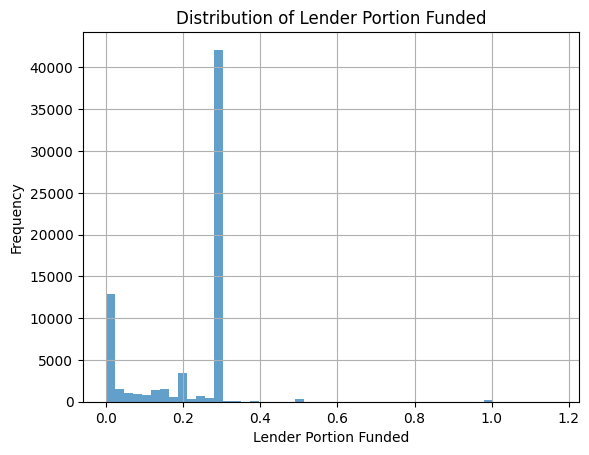

In [20]:
train['Lender_portion_Funded'].hist(bins=50, alpha=0.7)
plt.title('Distribution of Lender Portion Funded')
plt.xlabel('Lender Portion Funded')
plt.ylabel('Frequency')
plt.show()

# Feature Enginnering

In [21]:
train['Loan_Cost_Ratio'] = train['Total_Amount_to_Repay'] / train['Total_Amount']
test['Loan_Cost_Ratio'] = test['Total_Amount_to_Repay'] / test['Total_Amount']

In [22]:
# Convert columns to datetime
train['disbursement_date'] = pd.to_datetime(train['disbursement_date'])
train['due_date'] = pd.to_datetime(train['due_date'])
# Convert columns to datetime
test['disbursement_date'] = pd.to_datetime(test['disbursement_date'])
test['due_date'] = pd.to_datetime(test['due_date'])

In [23]:
train['Disbursement_Month'] = train['disbursement_date'].dt.month
test['Disbursement_Month'] = test['disbursement_date'].dt.month

In [24]:
train['Disbursement_Year'] = train['disbursement_date'].dt.year
test['Disbursement_Year'] = test['disbursement_date'].dt.year

In [25]:
train.loc[train['Lender_portion_Funded'] > 1, 'Lender_portion_Funded']

,Lender_portion_Funded
30684,1.168119


In [26]:
train = train[train['Lender_portion_Funded'] <= 1]

In [27]:
# Group by month to see trends
seasonal_trends = train.groupby('Disbursement_Month')['target'].mean()
print(seasonal_trends)

Disbursement_Month
1     0.108883
2     0.179191
3     0.179641
4     0.143541
5     0.147929
6     0.101240
7     0.008103
8     0.018462
9     0.013463
10    0.016044
11    0.015062
12    0.122222
Name: target, dtype: float64


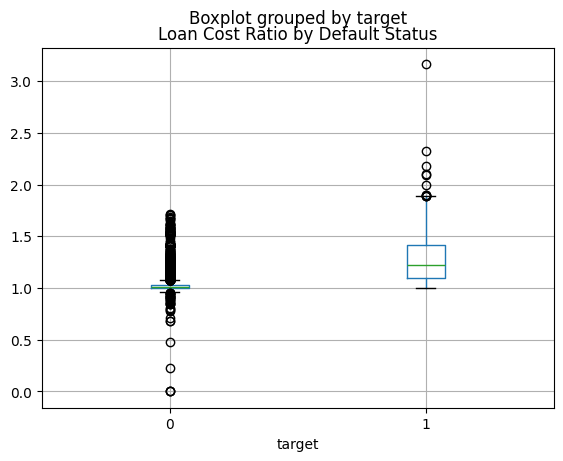

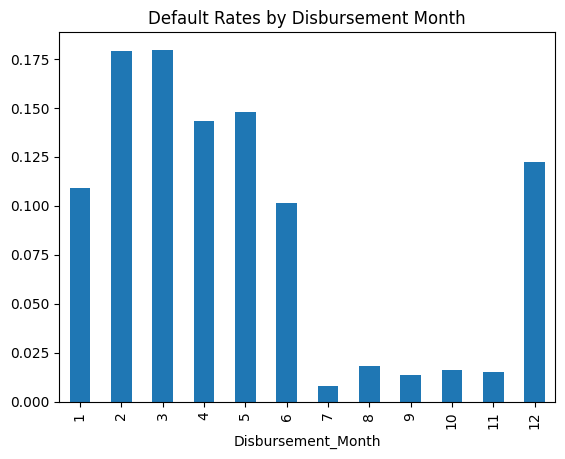

In [28]:
# Visualize loan cost ratio impact
train.boxplot(column='Loan_Cost_Ratio', by='target')
plt.title('Loan Cost Ratio by Default Status')
plt.show()

# Visualize seasonal trends
seasonal_trends.plot(kind='bar')
plt.title('Default Rates by Disbursement Month')
plt.show()

In [29]:
train.isna().sum().sum()

0

In [30]:
train[numerical_columns]

,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,target,real_interest_rate_at_disbursement,Inflation_consumer_prices_(annual %)_at_disbursement,"Official_exchange_rate_(LCU per US$, period average)_at_disbursement",Average_precipitation_in_depth_(mm per year)_at_disbursement,...,Unemployment_rate_at_disbursement,real_interest_rate_at_due,Inflation_consumer_prices_(annual %)_at_due,"Official_exchange_rate_(LCU per US$, period average)_at_due",Average_precipitation_in_depth_(mm per year)_at_due,Deposit_interest_rate_(%)_at_due,Lending_interest_rate_(%)_at_due,"Interest_rate_spread_(lending rate minus deposit rate, %)_at_due",Fossil_fuel_energy_consumption_(% of total)_at_due,Unemployment_rate_at_due
0,8448.0,8448.0,7,120.85,0.014305,0,5.968447,7.659863,117.865989,-9999.0,...,5.805,5.968447,7.659863,117.865989,-9999.0,7.145176,12.335841,5.190665,-9999.0,5.805
1,25895.0,25979.0,7,7768.50,0.300000,0,5.968447,7.659863,117.865989,-9999.0,...,5.805,5.968447,7.659863,117.865989,-9999.0,7.145176,12.335841,5.190665,-9999.0,5.805
2,6900.0,7142.0,7,1380.00,0.200000,0,6.546517,7.671396,139.846384,-9999.0,...,5.682,6.546517,7.671396,139.846384,-9999.0,9.167690,13.588502,4.420812,-9999.0,5.682
3,8958.0,9233.0,7,2687.40,0.300000,0,5.968447,7.659863,117.865989,-9999.0,...,5.805,5.968447,7.659863,117.865989,-9999.0,7.145176,12.335841,5.190665,-9999.0,5.805
4,4564.0,4728.0,7,1369.20,0.300000,0,5.968447,7.659863,117.865989,-9999.0,...,5.805,5.968447,7.659863,117.865989,-9999.0,7.145176,12.335841,5.190665,-9999.0,5.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68649,1460.0,1515.0,7,438.00,0.300000,0,5.968447,7.659863,117.865989,-9999.0,...,5.805,5.968447,7.659863,117.865989,-9999.0,7.145176,12.335841,5.190665,-9999.0,5.805
68650,5029.0,5116.0,7,1508.70,0.300000,0,5.968447,7.659863,117.865989,-9999.0,...,5.805,5.968447,7.659863,117.865989,-9999.0,7.145176,12.335841,5.190665,-9999.0,5.805
68651,5289.0,5289.0,7,1586.70,0.300000,0,5.968447,7.659863,117.865989,-9999.0,...,5.805,5.968447,7.659863,117.865989,-9999.0,7.145176,12.335841,5.190665,-9999.0,5.805
68652,3334.0,3334.0,7,741.09,0.222283,0,5.968447,7.659863,117.865989,-9999.0,...,5.805,5.968447,7.659863,117.865989,-9999.0,7.145176,12.335841,5.190665,-9999.0,5.805


#Modeling

In [32]:
numerical_columns = train.select_dtypes(include=['number']).columns.tolist()
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()

def filter_id_columns(columns):
    id_columns = [col for col in columns if 'id' in col.lower()]
    filtered_columns = [col for col in columns if col not in id_columns]
    return filtered_columns, id_columns

numerical_columns, id_columns_numerical = filter_id_columns(numerical_columns)
categorical_columns, id_columns_categorical = filter_id_columns(categorical_columns)

id_columns = id_columns_numerical + id_columns_categorical

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)
print("ID columns:", id_columns)

Numerical columns: ['Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'target', 'real_interest_rate_at_disbursement', 'Inflation_consumer_prices_(annual %)_at_disbursement', 'Official_exchange_rate_(LCU per US$, period average)_at_disbursement', 'Average_precipitation_in_depth_(mm per year)_at_disbursement', 'Deposit_interest_rate_(%)_at_disbursement', 'Lending_interest_rate_(%)_at_disbursement', 'Interest_rate_spread_(lending rate minus deposit rate, %)_at_disbursement', 'Fossil_fuel_energy_consumption_(% of total)_at_disbursement', 'Unemployment_rate_at_disbursement', 'real_interest_rate_at_due', 'Inflation_consumer_prices_(annual %)_at_due', 'Official_exchange_rate_(LCU per US$, period average)_at_due', 'Average_precipitation_in_depth_(mm per year)_at_due', 'Deposit_interest_rate_(%)_at_due', 'Lending_interest_rate_(%)_at_due', 'Interest_rate_spread_(lending rate minus deposit rate, %)_at_due', 'Fossil_fuel_energy_consumption_(%

In [33]:
useable_train = train[numerical_columns+['Lender_portion_to_be_repaid', 'customer_id']]
X = useable_train.drop(columns=['target'])
usable_testt = test[X.columns]
y = useable_train['target']
groups = train['customer_id']

In [34]:
# Initialize models
logistic = LogisticRegression(max_iter=1000)
xgb = XGBClassifier(verbosity=0, seed=SEED)
lgbm = LGBMClassifier(verbosity=0, seed=SEED)
catboost = CatBoostClassifier(verbose=0, random_seed=SEED)

In [35]:
# Cross-validation setup
FOLDS = 5
sgkf = StratifiedGroupKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
model_f1_scores = {'Logistic': [], 'XGB': [], 'LGBM': [], 'CatBoost': []}
test_predictions = {'Logistic': np.zeros(len(test)),
                    'XGB': np.zeros(len(test)),
                    'LGBM': np.zeros(len(test)),
                    'CatBoost': np.zeros(len(test))}

In [38]:
# Perform StratifiedGroupKFold cross-validation
usable_test = usable_testt.drop(columns=['customer_id'])
X.columns = X.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
usable_test.columns = usable_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y, groups=groups)):
    print(f"Fold {fold + 1}/{FOLDS}")
    xtrain, xtest = X.iloc[train_idx], X.iloc[val_idx]
    ytrain, ytest = y.iloc[train_idx], y.iloc[val_idx]
    xtrain = xtrain.drop(columns=['customer_id'])
    xtest = xtest.drop(columns=['customer_id'])


    # Fit and predict with Logistic Regression
    logistic.fit(xtrain, ytrain)
    logistic_pred = logistic.predict_proba(xtest)[:, 1]
    model_f1_scores['Logistic'].append(f1_score(ytest, logistic_pred.round()))
    test_predictions['Logistic'] += logistic.predict_proba(usable_test)[:, 1] / FOLDS

    # Fit and predict with XGBoost
    xgb.fit(xtrain, ytrain)
    xgb_pred = xgb.predict_proba(xtest)[:, 1]
    model_f1_scores['XGB'].append(f1_score(ytest, xgb_pred.round()))
    test_predictions['XGB'] += xgb.predict_proba(usable_test)[:, 1] / FOLDS

    # Fit and predict with LightGBM
    lgbm.fit(xtrain, ytrain)
    lgbm_pred = lgbm.predict_proba(xtest)[:, 1]
    model_f1_scores['LGBM'].append(f1_score(ytest, lgbm_pred.round()))
    test_predictions['LGBM'] += lgbm.predict_proba(usable_test)[:, 1] / FOLDS

    # Fit and predict with CatBoost
    catboost.fit(xtrain, ytrain)
    catboost_pred = catboost.predict_proba(xtest)[:, 1]
    model_f1_scores['CatBoost'].append(f1_score(ytest, catboost_pred.round()))
    test_predictions['CatBoost'] += catboost.predict_proba(usable_test)[:, 1] / FOLDS

Fold 1/5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2/5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3/5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4/5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5/5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
for model, scores in model_f1_scores.items():
    print(f"{model}: Mean F1 Score = {np.mean(scores):.4f}")

Logistic: Mean F1 Score = 0.1072
XGB: Mean F1 Score = 0.8178
LGBM: Mean F1 Score = 0.8235
CatBoost: Mean F1 Score = 0.8281


In [44]:
ss['target'] = test_predictions['LGBM'].round()
ss.to_csv('ss_LGBM_average.csv', index=False)